In [1]:
import sys
print(f"Environment: {sys.executable}")

Environment: /n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python3


In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
model_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-15-10-35-59/")
# model_directory= '/n/groups/datta/jlove/data/rat_seq/6cam/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-26-18-03-03'

In [7]:
!ls {model_directory}

20240815_103613  epoch_280.pth	epoch_300.pth	 rtmdet_s_8xb32-300e_coco.py
config.py	 epoch_290.pth	last_checkpoint


In [8]:
config_loc = model_directory / 'config.py'
checkpoint_loc = config_loc.parent / 'epoch_300.pth'

In [9]:
log_file = np.sort(list(model_directory.glob('*/*.log')))[-1]
with open(log_file, 'r') as file:
    log_info = file.read()
loss_lines = [i for i in log_info.split('\n') if ' loss: ' in i]
loss = [float(i.split('  loss: ')[1].split('  loss_cls:')[0]) for i in loss_lines]

Text(0, 0.5, 'Training Loss')

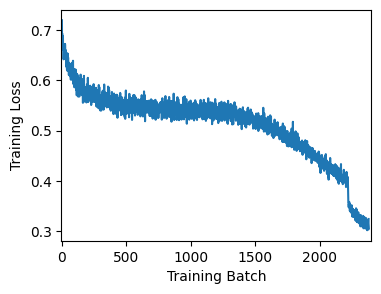

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(len(loss[20:])), loss[20:])
ax.set_xlim([-5, len(loss)])
ax.set_xlabel('Training Batch')
ax.set_ylabel('Training Loss')

### Load the inferencer

In [11]:
from mmdet.apis import DetInferencer

In [12]:
# Choose to use a config
config = config_loc.as_posix()
# Setup a checkpoint file to load
checkpoint = checkpoint_loc.as_posix()
# Set the device to be used for evaluation
device = 'cuda:0'

In [13]:
# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-15-10-35-59/epoch_300.pth
08/27 09:04:45 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [14]:
# load a test image
# sample_image = "/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/example_data/test_mouse.png"
sample_image = "/n/groups/datta/jlove/data/rat_seq/6cam/instalabelv2/images/24-08-13-14-17-49-180724.side4_14125.jpg"
image = Image.open(sample_image)
image_array = np.array(image)
image_array.shape

(1200, 1920, 3)

In [15]:
# run inference
result = inferencer(image_array[:,:,:3], out_dir='/tmp', pred_score_thr=0.3)

Output()

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/torch/functional.py:504: UserWarning:
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at
/opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [16]:
result.keys()

dict_keys(['predictions', 'visualization'])

(0.0, 10.0)

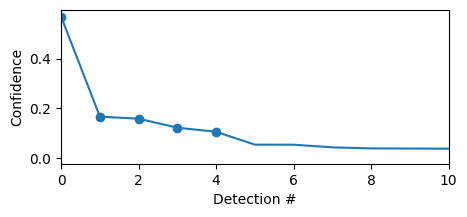

In [17]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(result['predictions'][0]['scores'])
ax.scatter(np.arange(5), result['predictions'][0]['scores'][:5])
ax.set_xlabel('Detection #')
ax.set_ylabel('Confidence')
ax.set_xlim([0,10])

### Plot detections

In [18]:
import matplotlib.patches as patches

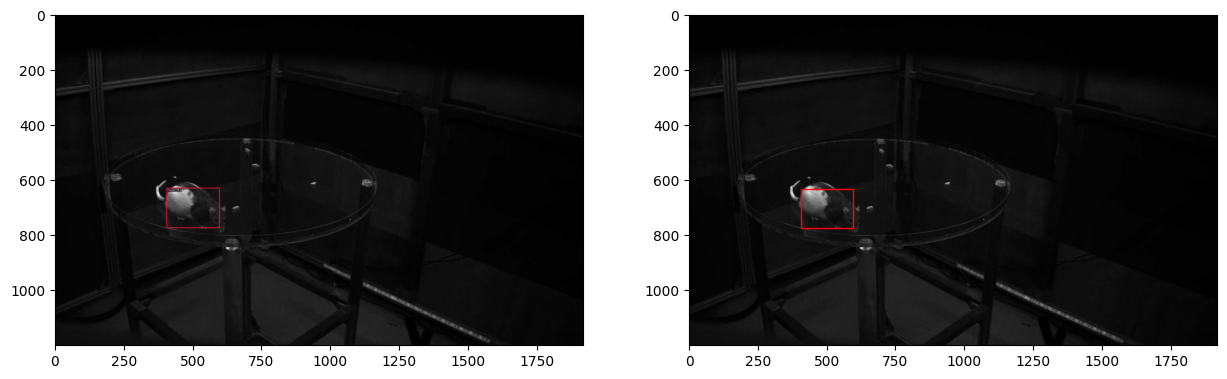

In [19]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2)
axs[0].imshow(result['visualization'][0])

ax = axs[1]
ax.imshow(image_array)
for i in range(1):
    x_min, y_min, x_max, y_max = result['predictions'][0]['bboxes'][i]
    width = x_max - x_min
    height = y_max - y_min
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the Axes
    ax.add_patch(rect)

In [20]:
x_min, y_min, x_max, y_max = result['predictions'][0]['bboxes'][0]

x_cent = x_min + (x_max - x_min)
y_cent = y_min + (y_max - y_min)

In [21]:
def crop_image(image, centroid, crop_size):
    """Crop an image around a centroid.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to crop.

    centroid: tuple of int
        (x,y) coordinates of the centroid.

    crop_size: int or tuple(int,int)
        Size of the crop around the centroid. Either a single int for a square
        crop, or a tuple of ints (w,h) for a rectangular crop.


    Returns
    -------
    image: ndarray of shape (crop_size, crop_size, 3)
        Cropped image.
    """
    if isinstance(crop_size, tuple):
        w, h = crop_size
    else:
        w, h = crop_size, crop_size
    x, y = int(centroid[0]), int(centroid[1])

    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)
    x_max = min(image.shape[1], x + w // 2)
    y_max = min(image.shape[0], y + h // 2)

    cropped = image[y_min:y_max, x_min:x_max]
    padded = np.zeros((h, w, *image.shape[2:]), dtype=image.dtype)
    pad_x = max(w // 2 - x, 0)
    pad_y = max(h // 2 - y, 0)
    padded[
        pad_y : pad_y + cropped.shape[0], pad_x : pad_x + cropped.shape[1]
    ] = cropped
    return padded


In [22]:
cropped = crop_image(image_array, [x_cent, y_cent], 512)

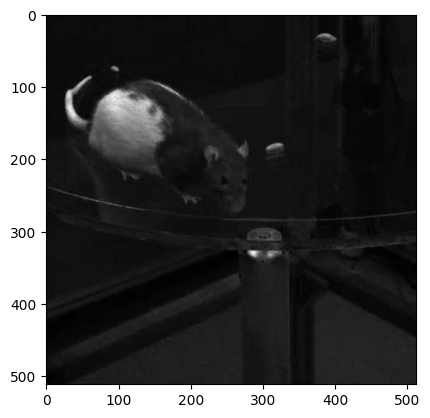

In [23]:
plt.imshow(cropped)

In [24]:
plt.imsave('./rat_cropped.jpg', cropped)

In [34]:
pwd

'/n/groups/datta/jlove/data/rat_seq/6cam/tim_code/multicamera_labelling_and_training/notebooks'